# Smoothed MINE

In [1]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from src.utils import *
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter

In [2]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=20, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-20, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=40, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-3, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=1e-6, help="smooth parameter")
parser.add_argument("--reg", type=int, default=0, help="if apply regularization")
parser.add_argument("--n_epoch", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [4]:
continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results
overwrite = True  # set to True to overwrite previously stored results

In [5]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

ref_X, ref_Y = shuffle_data(X, Y, opt.sample_size)
ref_XY = torch.cat([ref_X, ref_Y], dim = 1)
train_data = torch.cat([XY, ref_XY], dim = 0)
train_label = torch.cat([torch.ones([opt.sample_size,1]), torch.zeros([opt.sample_size, 1])], dim=0)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=20)
# clf = DecisionTreeClassifier(min_samples_leaf=400, max_depth=10)
# clf = RandomForestClassifier(n_estimators=10, min_samples_split=5)
clf.fit(train_data.cpu().numpy(),  train_label.cpu().numpy())

DecisionTreeClassifier(max_depth=20, min_samples_leaf=20)

In [7]:
path = clf.cost_complexity_pruning_path(train_data.cpu().numpy(), train_label.cpu().numpy())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp = ccp_alphas[round(len(ccp_alphas)/2)]
clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=20, ccp_alpha=ccp)
clf.fit(train_data.cpu().numpy(),  train_label.cpu().numpy())

clf.score(train_data.cpu().numpy(),  train_label.cpu().numpy())

0.75875

In [8]:
# construct the data needs to train and predict the label
x_tile = X.unsqueeze(0).repeat((opt.sample_size, 1, 1))
y_tile = Y.unsqueeze(1).repeat((1, opt.sample_size, 1))
data_matrix = torch.cat([x_tile, y_tile], dim = -1)
mask =  torch.ones([opt.sample_size]).diag().bool().cuda()

mix_data = torch.cat((data_matrix[mask,:].repeat(opt.sample_size-1, 1), data_matrix[~mask,:].reshape(-1, opt.d*2)), dim=0)

mix_data_X, mix_data_Y = mix_data[:,:opt.d], mix_data[:,opt.d:]
hard_label = torch.cat((torch.ones(opt.sample_size*(opt.sample_size-1), 1), torch.zeros(opt.sample_size*(opt.sample_size-1), 1)), dim=0)
prob_data = torch.Tensor(clf.predict_proba(mix_data.cpu().numpy())[:,1]).reshape(-1, 1)

## Initialize the model.

In [9]:
name = f'./results/Smoothed_MINE_dim{opt.d}_reg{opt.reg}_alpha{opt.alpha}'   # filename
chkpt_name = name+'.pt'      # checkpoint

from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/Smoothed_MINE_dim{opt.d}_reg{opt.reg}_alpha{opt.alpha}/{TIMESTAMP}')
discriminator = Net(input_size=opt.d*2, hidden_layers=2, hidden_size=100)

# move NN model to GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [10]:
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [11]:
def smooth_loss(net, data_label, batch_XY, writer=None, epoch=None, reg=False):
    a = (net(batch_XY)*data_label*2).mean()
    b = torch.logsumexp(net(batch_XY)+torch.log(1-data_label), dim=0) - np.log(2*batch_XY.shape[0])

    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', b, epoch)

    if reg:
        return a - b - b**2
    else:
        return a - b

In [12]:
smoothed_label = (1-opt.alpha)*hard_label + opt.alpha*prob_data
if continue_train:
    _iter = 0
    for i in range(opt.n_epoch):
        idx = np.random.permutation(2*opt.sample_size*(opt.sample_size-1))
        for j in range(opt.n_iters_1epoch):
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_XY = mix_data[batch_idx]
            smoothed_label_b = smoothed_label[batch_idx]

            optimizer_D.zero_grad()
            loss = - smooth_loss(discriminator, smoothed_label_b, batch_XY, reg=opt.reg) # negative infonce_bound as the loss
            loss.backward()

            optimizer_D.step()
            with torch.no_grad():
                # mi_est = smooth_loss(discriminator, clf, X, Y, alpha=0.2)
                mi_est = smooth_loss(discriminator, smoothed_label, mix_data)
            mi_list.append(mi_est.item())

            writer.add_scalar('mi_list', mi_est.item(), _iter)
            writer.add_scalar('loss', loss, _iter)
        _iter += 1
        if _iter%100==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))
            fig = plot_fig(discriminator, X, Y, opt.d if opt.d<6 else 6)
            writer.add_figure('heatmap', fig, _iter)
            writer.add_histogram('first layer', discriminator.fc[0].weight.data, _iter)
            writer.add_histogram('second layer', discriminator.fc[1].weight.data, _iter)
            writer.add_histogram('third layer', discriminator.fc[2].weight.data, _iter)

            writer.add_histogram('first layer (grad)', discriminator.fc[0].weight.grad.data, _iter)
            writer.add_histogram('second layer (grad)', discriminator.fc[1].weight.grad.data, _iter)
            writer.add_histogram('third layer (grad)', discriminator.fc[2].weight.grad.data, _iter)

writer.add_graph(discriminator, (XY,))
writer.close()

Iternation: 100, loss: -15.714695, mi_est: 15.893263
Iternation: 200, loss: -15.830086, mi_est: 16.116024
Iternation: 300, loss: -17.182873, mi_est: 16.411079
Iternation: 400, loss: -16.396870, mi_est: 16.455177
Iternation: 500, loss: -16.944698, mi_est: 16.426544
Iternation: 600, loss: -16.785007, mi_est: 16.465553
Iternation: 700, loss: -16.347672, mi_est: 16.482712
Iternation: 800, loss: -16.624611, mi_est: 16.545685
Iternation: 900, loss: -16.331551, mi_est: 16.502869
Iternation: 1000, loss: -16.334614, mi_est: 16.561760


In [13]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

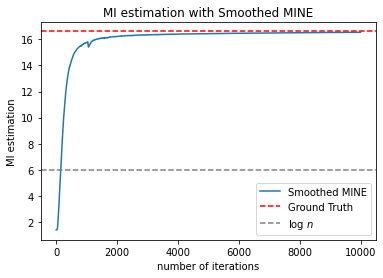

In [18]:
plt.plot(mi_copy, label='Smoothed MINE')

plt.axhline(Ground_truth,label='Ground Truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('MI estimation with Smoothed MINE')
plt.legend()
plt.savefig(f'results/Smoothed_InfoMINE_dim{opt.d}_ma{ma_rate}.pdf')

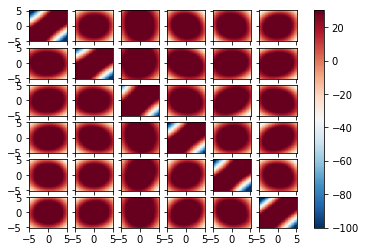

In [17]:
heatmap = plot_fig(discriminator, X, Y, vmin=-100, vmax=30, d=6)
# plt.savefig(f'./results/heatmap_smoothed_MINE_dim{opt.d}.pdf')